In [ ]:
# The idea of this notebook is to have a look at what is actually going on with the states and if predictions make sense

In [1]:
import pandas as pd
from chess_ai.rlagent.muzero.utils import MOVES, encode_state
from chess_ai.rlagent.muzero.models import AlphazeroNetSupervised
from chess_ai.rlagent.muzero.utils import get_root_dir
import torch
import numpy as np
from chess_python.chess import Chess
from pathlib import Path
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F

In [2]:
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
class ConvBlock(nn.Module):
    def __init__(self):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(256)

    def forward(self, s):
        s = s.view(-1, 1, 8, 8)  # batch_size x channels x board_x x board_y
        s = F.relu(self.bn1(self.conv1(s)))
        return s

class ResBlock(nn.Module):
    def __init__(self, inplanes=256, planes=256, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = F.relu(out)
        return out
    
class OutBlock(nn.Module):
    def __init__(self):
        super(OutBlock, self).__init__()
        self.conv = nn.Conv2d(256, 1, kernel_size=1) # value head
        self.bn = nn.BatchNorm2d(1)
        self.fc1 = nn.Linear(8*8, 64)
        self.fc2 = nn.Linear(64, 1)
        
        self.conv1 = nn.Conv2d(256, 128, kernel_size=1) # policy head
        self.bn1 = nn.BatchNorm2d(128)
        self.fc = nn.Linear(8*8*128, 4208)
    
    def forward(self,s):
        v = F.relu(self.bn(self.conv(s))) # value head
        v = v.view(-1, 8*8)  # batch_size X channel X height X width
        v = F.relu(self.fc1(v))
        v = F.tanh(self.fc2(v))
        
        p = F.relu(self.bn1(self.conv1(s))) # policy head
        p = p.view(-1, 8*8*128)
        p = self.fc(p)
        p = F.softmax(p, dim=1)
        return v, p
    
class ChessNet(nn.Module):
    def __init__(self):
        super(ChessNet, self).__init__()
        self.conv = ConvBlock()
        for i in range(10):
            setattr(self, f"res_{i}",ResBlock())
        self.outblock = OutBlock()
    
    def forward(self,s):
        s = self.conv(s)
        for i in range(10):
            s = getattr(self, f"res_{i}")(s)
        s = self.outblock(s)
        return s

# check if the model is training

In [20]:
buffer = pd.read_feather(Path("../") /"chess_ai"/ "rlagent" / "data" / "dataframe" / f"buffer_df.feather").sample(1000)

In [21]:
buffer["hash_state"] = buffer.state.apply(lambda x: hash(tuple(x)))

In [22]:
buffer.hash_state.value_counts()

-6989483368135847075    7
-982962998073096265     2
-4867639744452209610    2
-4383868005907547835    1
-1001673924815051200    1
                       ..
 7031122901129260673    1
 2181368398483504873    1
 2380947972601168910    1
 9193560650481540140    1
-285722230033553190     1
Name: hash_state, Length: 992, dtype: int64

In [23]:
hash_state =  -6989483368135847075 

In [24]:
buffer["hash_state"]

71995     6377972056538571295
196059   -5259073649603534624
61518     8248529576044715771
154746     844734928381685309
98488     7504471850920474954
                 ...         
39885      986212807354547726
105909    4733102013570532833
39656     3412865322217475391
85522     3449506590965088543
152014    -285722230033553190
Name: hash_state, Length: 1000, dtype: int64

In [25]:
buffer["state_64"] = buffer.state.apply(lambda x: x[:-3])
x = torch.tensor(np.stack(buffer.state_64.values, axis=0), dtype=torch.float32).view(-1,64)
#x = torch.tensor(np.stack(buffer.state.values, axis=0), dtype=torch.float32)
#x = torch.tensor(buffer[buffer.hash_state==hash_state].iloc[0].state, dtype=torch.float32).view(-1,67)

In [31]:
# model = AlphazeroNetSupervised()
# model.load_state_dict(torch.load("../chess_ai/rlagent/checkpoints/nn_supervised_conv_20.pth"))
# model.eval()
model = ChessNet()
model.load_state_dict(torch.load("../chess_ai/rlagent/checkpoints/nn_supervised_conv_kaggle (9).pth", map_location=torch.device('cpu')))
model.eval()

ChessNet(
  (conv): ConvBlock(
    (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_0): ResBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_1): ResBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (r

In [32]:
print(buffer[buffer.hash_state==hash_state].iloc[0].value)
value, policy = model(x)

#print(value)

0.025494474312226956


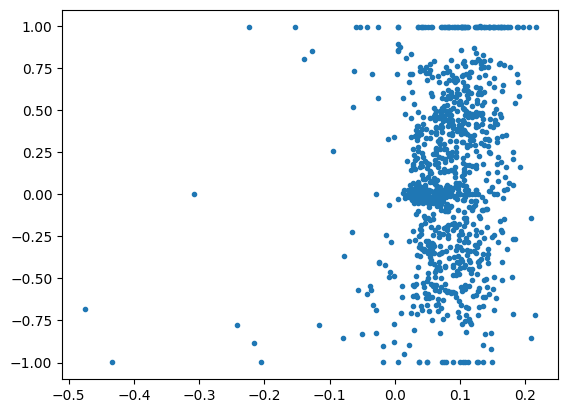

In [33]:
plt.plot(value.detach().numpy(), buffer.value.values, ".")

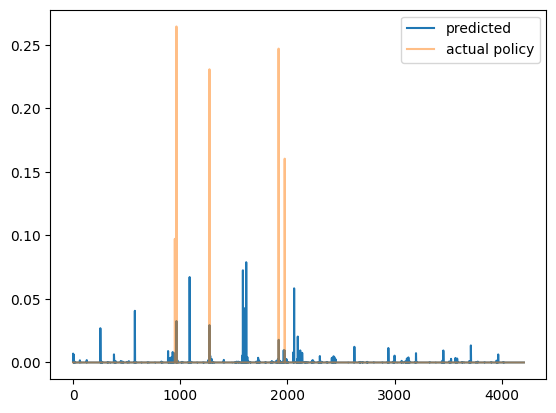

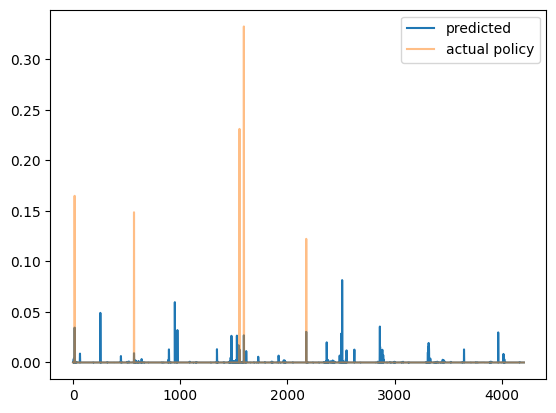

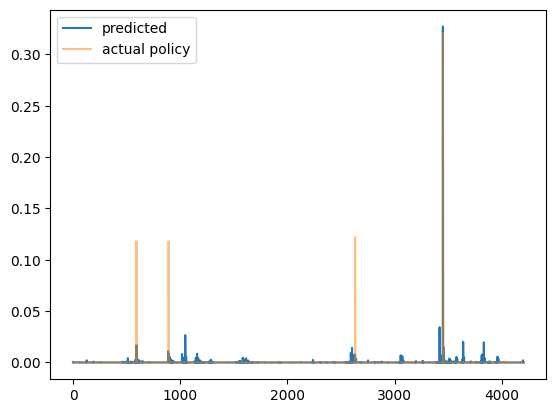

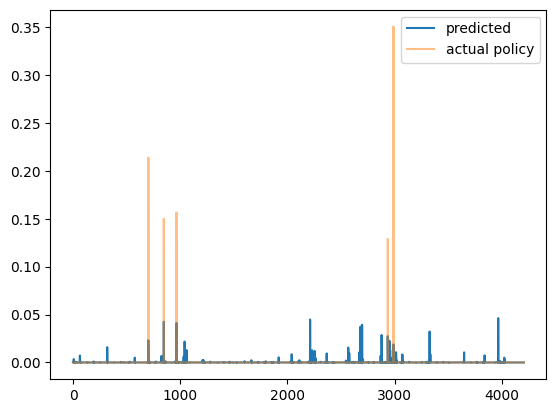

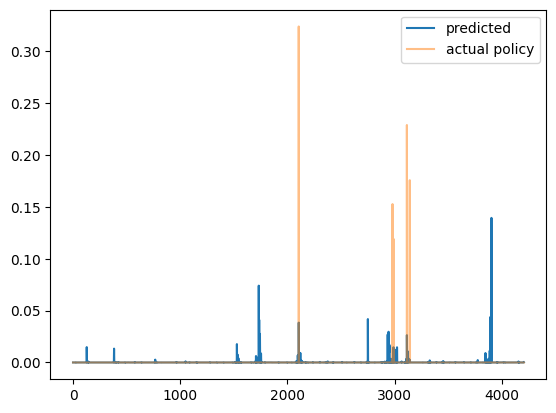

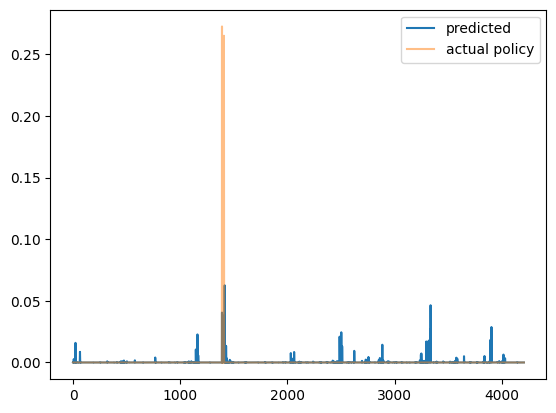

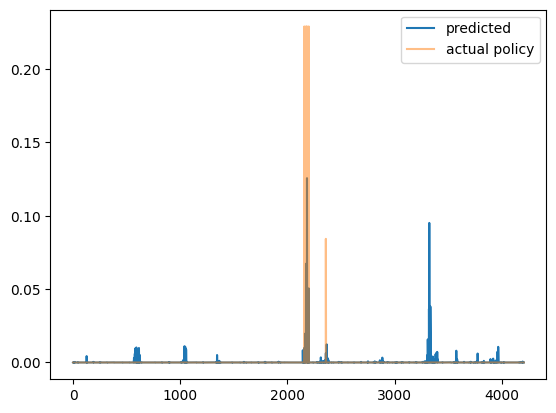

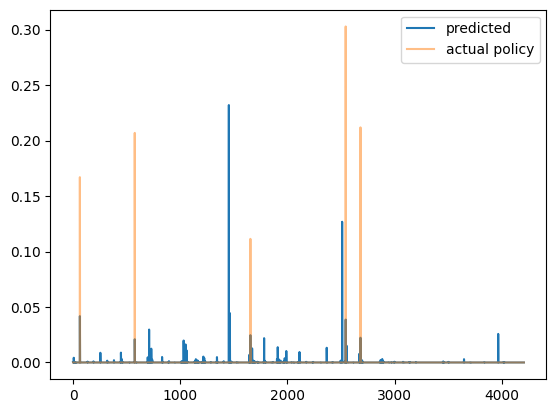

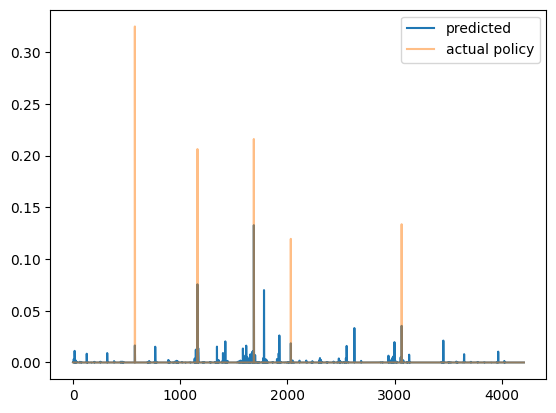

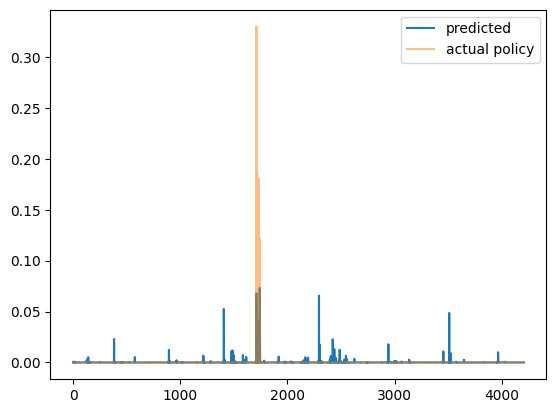

In [34]:
for i in range(10):
    plt.plot(policy[i].detach().numpy(), label="predicted")
    plt.plot(buffer.iloc[i].policy, alpha=0.5, label="actual policy")
    plt.legend()
    plt.show()

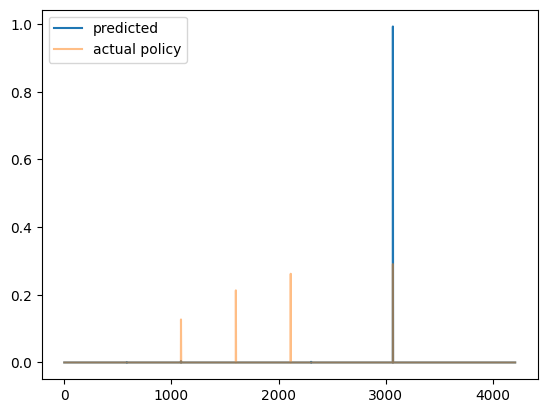

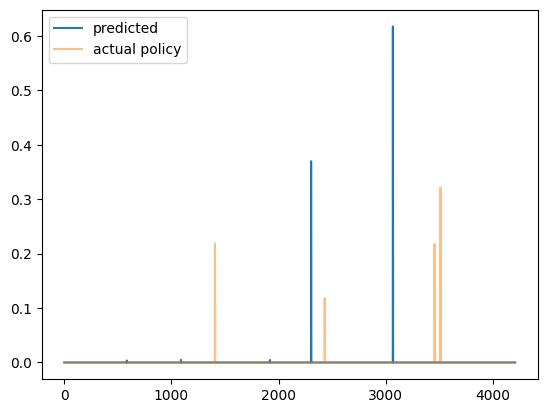

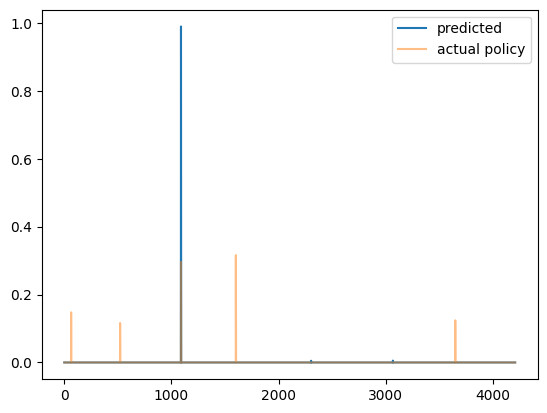

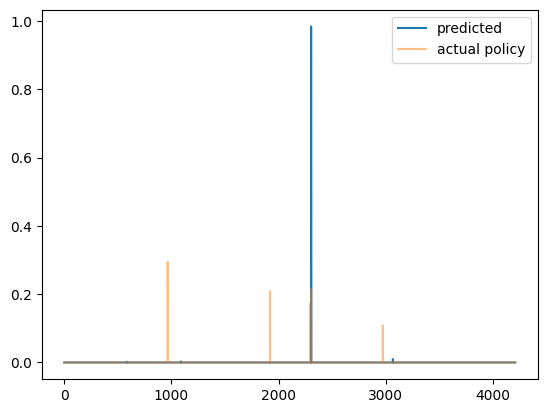

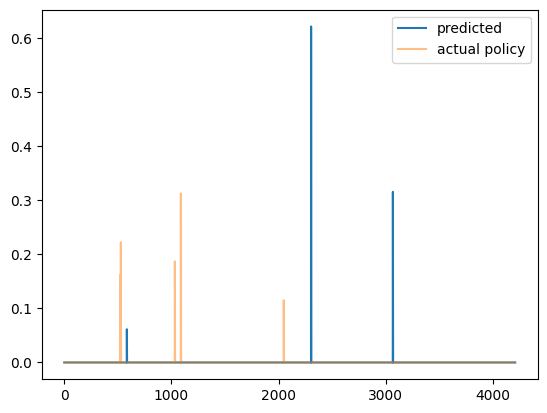

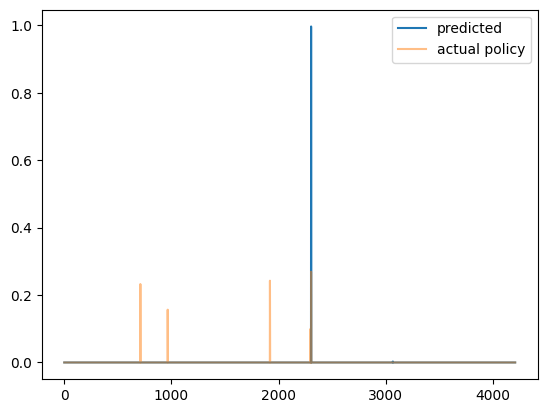

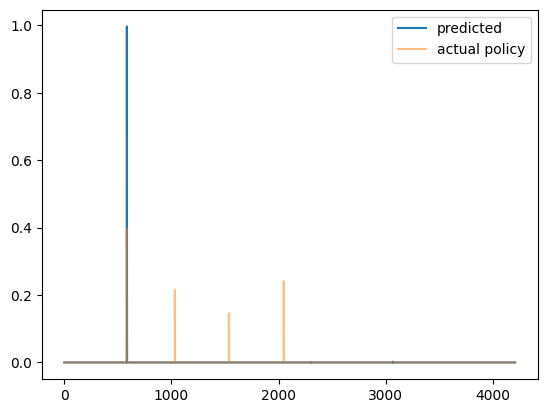

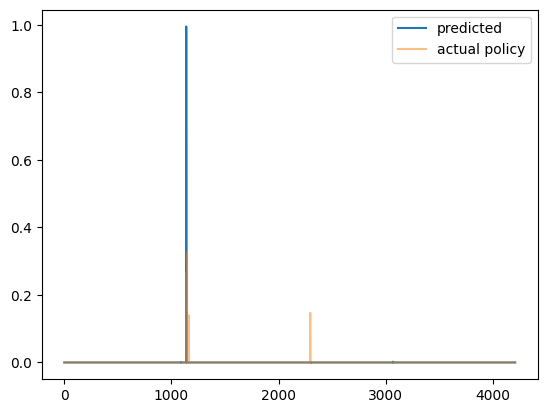

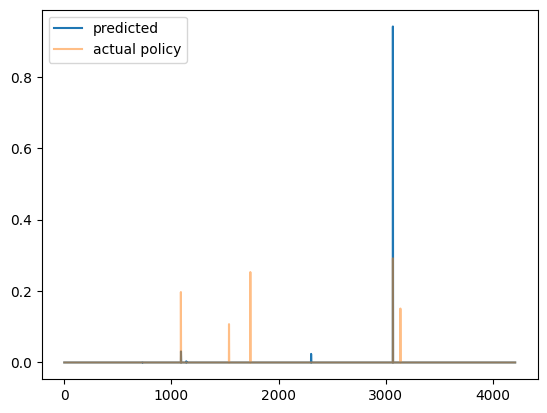

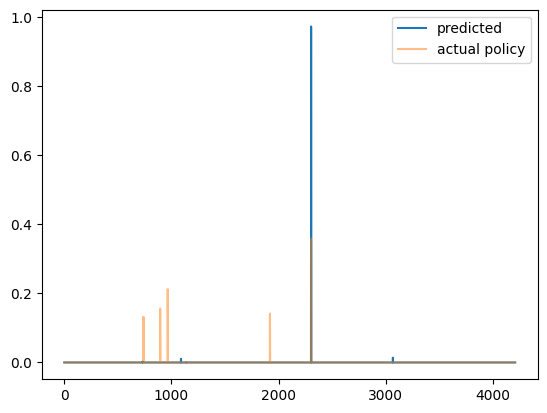

In [30]:
for i in range(10):
    plt.plot(policy[i].detach().numpy(), label="predicted")
    plt.plot(buffer.iloc[i].policy, alpha=0.5, label="actual policy")
    plt.legend()
    plt.show()

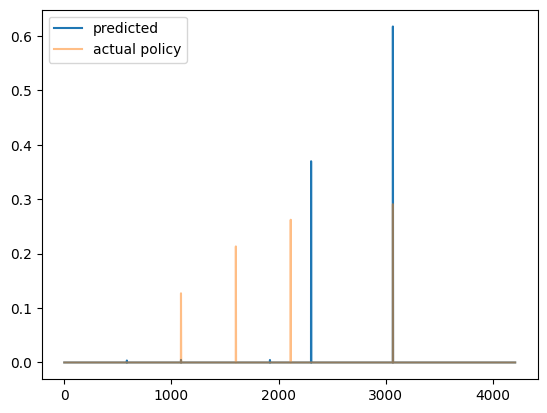

In [26]:
plt.plot(policy[1].detach().numpy(), label="predicted")
plt.plot(buffer[buffer.hash_state==hash_state].iloc[0].policy, alpha=0.5, label="actual policy")
plt.legend()

0.0002376425855513308
0.0002376425855513308


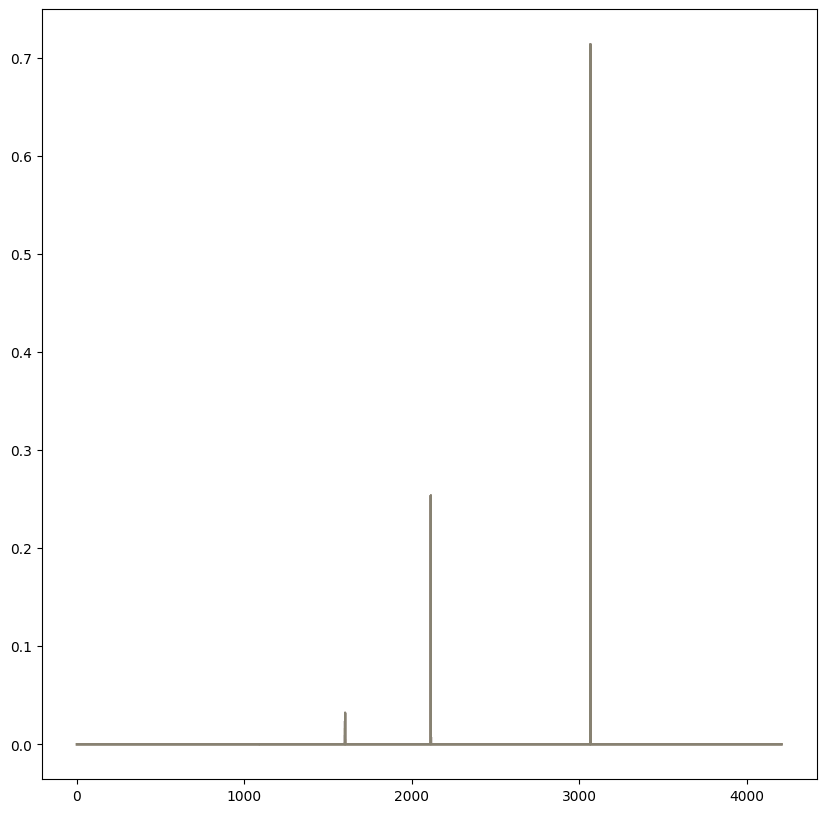

In [117]:
plt.figure(figsize=(10,10))
list_mean = []
for i in range(40):
    plt.plot(buffer[buffer.hash_state==hash_state].iloc[i].policy, alpha=0.1)
    #print(buffer[buffer.hash_state==hash_state].iloc[i].value)
    list_mean.append(buffer[buffer.hash_state==hash_state].iloc[i].policy.mean())
print(max(list_mean))
print(min(list_mean))


In [89]:
import os
os.getcwd()

'/Users/pablocanadapereira/Desktop/Projects/chess-ai/notebooks'

In [90]:

buffer = pd.read_feather(Path("../") /"chess_ai"/ "rlagent" / "data" / "dataframe" / f"buffer_df.feather")


In [91]:
df = buffer

In [92]:
#df = pd.read_feather("../supervised_dataset_2.feather")

In [93]:
#df["value"] = 1/(1+np.exp(-0.01*df.evaluation))

In [94]:
df.value.min()

-0.9994563063989771

In [95]:
first_move = df.iloc[0].move
print(first_move)

b1c3


In [96]:
df.iloc[1].state, df.iloc[1].value

(array([ 4,  0,  3,  5,  6,  3,  2,  4,  1,  1,  1,  1,  1,  1,  1,  1,  0,
         0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,
        -1, -1, -1, -1, -1, -4, -2, -3, -5, -6, -3, -2, -4, -1,  0, 15]),
 0.005499944542337598)

In [108]:
df.iloc[3]

level_0                                                           3
index                                                           0_4
moves                                [d7d5, g8f6, c7c5, b8c6, a7a6]
move                                                           a7a6
state             [4, 0, 3, 5, 6, 3, 2, 4, 0, 1, 1, 1, 1, 1, 1, ...
fen               rnbqkbnr/pppp1ppp/4p3/8/8/P1N5/1PPPPPPP/R1BQKB...
scores_number                                 [15, 8, -5, -49, -35]
scores_softmax    [0.7249817734546079, 0.24283847599286498, 0.03...
value_number                                                     15
value                                                        0.0075
policy            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 3, dtype: object

In [97]:
pol = df.iloc[1].policy

In [98]:
pol.max()

0.9988281380226485

In [99]:
MOVES[df.iloc[1].policy.argmax()]

'd7d5'

In [100]:
model = AlphazeroNetSupervised()
model.load_state_dict(torch.load("../chess_ai/rlagent/checkpoints/nn_supervised.pth"))
model.eval()

AlphazeroNetSupervised(
  (l1): Linear(in_features=67, out_features=200, bias=True)
  (l2): Linear(in_features=200, out_features=1, bias=True)
  (l3): Linear(in_features=200, out_features=4208, bias=True)
  (activation): Tanh()
)

In [101]:
torch.tensor(df.iloc[1].state).view(-1,67)

tensor([[ 4,  0,  3,  5,  6,  3,  2,  4,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,
          2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1,
         -1, -1, -4, -2, -3, -5, -6, -3, -2, -4, -1,  0, 15]])

In [102]:
print(encode_state(Chess().move(first_move).state))

[4, 0, 3, 5, 6, 3, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -4, -2, -3, -5, -6, -3, -2, -4, -1, 0, 15]


In [103]:
value_pred_train, policy_pred_train = model(torch.tensor(df.iloc[1].state, dtype=torch.float32).view(-1,67))
value_pred, policy_pred = model(torch.tensor(encode_state(Chess().move(first_move).state), dtype=torch.float32).view(-1, 67))

In [104]:
print(value_pred_train, policy_pred_train)
print("Net pred", value_pred, policy_pred)

tensor([[-0.0364]], grad_fn=<TanhBackward0>) tensor([[2.8517e-12, 2.2832e-09, 2.8517e-12,  ..., 2.8517e-12, 2.8517e-12,
         2.8517e-12]], grad_fn=<SoftmaxBackward0>)
Net pred tensor([[-0.0364]], grad_fn=<TanhBackward0>) tensor([[2.8517e-12, 2.2832e-09, 2.8517e-12,  ..., 2.8517e-12, 2.8517e-12,
         2.8517e-12]], grad_fn=<SoftmaxBackward0>)


In [81]:
MOVES[policy_pred.argmax().detach().numpy()]

'd7d5'